# 20Newsgroup data

## Introduction

In this notebook, we will demonstrate how to use the following functions on the 20Newsgroup data
- fejad

Each document is associated with 1 of 20 newsgroup topics, organized at two
hierarchical levels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import relastat as rs

# pip install --upgrade git+ssh://git@github.com/anniegray52/relastat.git

## Data load

Import data and create dataframe.

In [2]:
newsgroups = fetch_20newsgroups() 

df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', n=1, expand=True)

In [3]:
df.head()

,data,target,target_names,layer1,layer2
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,rec,autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,comp,graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,sci,space


For a random sample of the data, create tf-idf features.

In [4]:
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

`rs.'matrix_from_text' - creates a Y matrix of tf-idf features. It takes in a dataframe and the column which contains the data. Further functionality includes: removing general stopwords, adding stopwords, removing email addresses, cleaning (lemmatize and remove symbol, lowercase letters) and a threshold for the min/max number of documents a word needs to appear in to be included.

In [5]:
Y, attributes = rs.matrix_from_text(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [6]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12804


Perform dimension selection using Wasserstein distances, see xxx for details

In [62]:
from scipy.sparse.linalg import svds
from scipy import sparse
from tqdm import tqdm


def WassersteinDimensionSelect(Y, dims, split=0.5):
    """ 
    Select the number of dimensions for Y using Wasserstein distances.  

    Parameters  
    ----------  
    Y : numpy.ndarray   
        The array of matrices.  
    dims : list of int  
        The dimensions to be considered.    
    split : float   
        The proportion of the data to be used for training. 

    Returns 
    ------- 
    ws : list of numpy.ndarray   
        The Wasserstein distances between the training and test data for each number of dimensions.    
    """

    try:
        import ot
    except ModuleNotFoundError:
        logging.error("ot not found, pip install pot")
    print('tensorflow warnings are seemingly a bug in ot, ignore them')

    n = Y.shape[0]
    idx = np.random.choice(range(n), int(n*split), replace=False)
    Y1 = Y[idx]

    mask = np.ones(Y.shape[0], dtype=bool)
    mask[idx] = False
    Y2 = Y[mask]

    if sparse.issparse(Y2):
        Y2 = Y2.toarray()
    n1 = Y1.shape[0]
    n2 = Y2.shape[0]
    max_dim = np.max(dims)
    U, S, Vt = sparse.linalg.svds(Y1, k=max_dim)
    S = np.flip(S)
    Vt = np.flip(Vt, axis=0)
    Ws = []
    for dim in dims:
        M = ot.dist((Y1 @ Vt.T[:, :dim]) @ Vt[:dim, :],
                    Y2, metric='euclidean')
        Ws.append(ot.emd2(np.repeat(1/n1, n1), np.repeat(1/n2, n2), M))
        print(
            f'Number of dimensions: {dim:d}, Wasserstein distance {Ws[-1]:.5f}')
    return Ws

In [63]:
w1 = WassersteinDimensionSelect(Y, range(50), split=0.5)

tensorflow warnings are seemingly a bug in ot, ignore them
Number of dimensions: 0, Wasserstein distance 1.00000
Number of dimensions: 1, Wasserstein distance 0.98935
Number of dimensions: 2, Wasserstein distance 0.98668
Number of dimensions: 3, Wasserstein distance 0.98494
Number of dimensions: 4, Wasserstein distance 0.98322
Number of dimensions: 5, Wasserstein distance 0.98220
Number of dimensions: 6, Wasserstein distance 0.98100
Number of dimensions: 7, Wasserstein distance 0.97999
Number of dimensions: 8, Wasserstein distance 0.97895
Number of dimensions: 9, Wasserstein distance 0.97800
Number of dimensions: 10, Wasserstein distance 0.97713
Number of dimensions: 11, Wasserstein distance 0.97661
Number of dimensions: 12, Wasserstein distance 0.97596
Number of dimensions: 13, Wasserstein distance 0.97535
Number of dimensions: 14, Wasserstein distance 0.97491
Number of dimensions: 15, Wasserstein distance 0.97465
Number of dimensions: 16, Wasserstein distance 0.97441
Number of dimens

In [64]:
np.argmin(w1)

34

In [19]:
w2 = wasserstein_dim_select(Y, split=0.5, rmin=0, rmax=50)

tensorflow warnings are seemingly a bug in ot, ignore them


100%|██████████| 51/51 [21:27<00:00, 25.25s/it]


In [22]:
w2

[0.9999999999999551,
 0.9894645561106418,
 0.9868417107998194,
 0.9851990417923819,
 0.983511363686631,
 0.9823118503720684,
 0.9810206703154659,
 0.9799698828429243,
 0.9789489688154067,
 0.9779822741290614,
 0.9772179841158537,
 0.9763769308367051,
 0.9757416369106101,
 0.9751520311410351,
 0.9749662840214465,
 0.9747120000391982,
 0.9744891675095487,
 0.9742655433059447,
 0.9740856656861033,
 0.9740461022531478,
 0.9739755682017969,
 0.9739138748645378,
 0.9738111933297094,
 0.9737239514938172,
 0.9737264859413038,
 0.9736768378238524,
 0.9736049334790836,
 0.9736494775986325,
 0.9735304267101726,
 0.9732967538748081,
 0.9733125913474836,
 0.9732847369840665,
 0.9732957663291998,
 0.9733035100002494,
 0.9732583751094255,
 0.9733230762897749,
 0.9733147675755904,
 0.9733410156549405,
 0.9733617173301602,
 0.9733997951080147,
 0.9734530807144185,
 0.9734238843219016,
 0.9731846859011007,
 0.9732766469594297,
 0.9733084768399388,
 0.9733241407111152,
 0.9734724368504591,
 0.97363586526

In [20]:
np.argmin(w2)

42

In [23]:
np.argmin(w1)

49

In [18]:
w1 = rs.WassersteinDimensionSelect(Y, split=0.5, dims = range(50))

tensorflow warnings are seemingly a bug in ot, ignore them


  2%|▏         | 1/50 [00:02<02:18,  2.83s/it]

Number of dimensions: 0, Wasserstein distance 1.00000


  4%|▍         | 2/50 [00:06<02:36,  3.25s/it]

Number of dimensions: 1, Wasserstein distance 0.98903


  6%|▌         | 3/50 [00:10<02:45,  3.51s/it]

Number of dimensions: 2, Wasserstein distance 0.98589


  8%|▊         | 4/50 [00:14<02:58,  3.88s/it]

Number of dimensions: 3, Wasserstein distance 0.98375


 10%|█         | 5/50 [00:19<03:06,  4.15s/it]

Number of dimensions: 4, Wasserstein distance 0.98184


 12%|█▏        | 6/50 [00:23<03:05,  4.21s/it]

Number of dimensions: 5, Wasserstein distance 0.98020


 14%|█▍        | 7/50 [00:28<03:08,  4.38s/it]

Number of dimensions: 6, Wasserstein distance 0.97874


 16%|█▌        | 8/50 [00:33<03:09,  4.50s/it]

Number of dimensions: 7, Wasserstein distance 0.97733


 18%|█▊        | 9/50 [00:38<03:12,  4.70s/it]

Number of dimensions: 8, Wasserstein distance 0.97616


 20%|██        | 10/50 [00:42<03:08,  4.71s/it]

Number of dimensions: 9, Wasserstein distance 0.97507


 22%|██▏       | 11/50 [00:47<03:05,  4.76s/it]

Number of dimensions: 10, Wasserstein distance 0.97381


 24%|██▍       | 12/50 [00:52<03:03,  4.82s/it]

Number of dimensions: 11, Wasserstein distance 0.97265


 26%|██▌       | 13/50 [00:57<02:57,  4.79s/it]

Number of dimensions: 12, Wasserstein distance 0.97163


 28%|██▊       | 14/50 [01:02<02:55,  4.88s/it]

Number of dimensions: 13, Wasserstein distance 0.97064


 30%|███       | 15/50 [01:08<02:58,  5.09s/it]

Number of dimensions: 14, Wasserstein distance 0.96964


 32%|███▏      | 16/50 [01:12<02:49,  4.99s/it]

Number of dimensions: 15, Wasserstein distance 0.96895


 34%|███▍      | 17/50 [01:18<02:47,  5.06s/it]

Number of dimensions: 16, Wasserstein distance 0.96835


 36%|███▌      | 18/50 [01:23<02:40,  5.02s/it]

Number of dimensions: 17, Wasserstein distance 0.96764


 38%|███▊      | 19/50 [01:27<02:34,  4.98s/it]

Number of dimensions: 18, Wasserstein distance 0.96704


 40%|████      | 20/50 [01:32<02:29,  4.97s/it]

Number of dimensions: 19, Wasserstein distance 0.96636


 42%|████▏     | 21/50 [01:38<02:26,  5.04s/it]

Number of dimensions: 20, Wasserstein distance 0.96576


 44%|████▍     | 22/50 [01:43<02:20,  5.03s/it]

Number of dimensions: 21, Wasserstein distance 0.96519


 46%|████▌     | 23/50 [01:48<02:15,  5.01s/it]

Number of dimensions: 22, Wasserstein distance 0.96457


 48%|████▊     | 24/50 [01:53<02:11,  5.05s/it]

Number of dimensions: 23, Wasserstein distance 0.96405


 50%|█████     | 25/50 [01:58<02:06,  5.05s/it]

Number of dimensions: 24, Wasserstein distance 0.96355


 52%|█████▏    | 26/50 [02:03<02:00,  5.01s/it]

Number of dimensions: 25, Wasserstein distance 0.96308


 54%|█████▍    | 27/50 [02:08<01:57,  5.10s/it]

Number of dimensions: 26, Wasserstein distance 0.96253


 56%|█████▌    | 28/50 [02:13<01:50,  5.01s/it]

Number of dimensions: 27, Wasserstein distance 0.96208


 58%|█████▊    | 29/50 [02:19<01:50,  5.28s/it]

Number of dimensions: 28, Wasserstein distance 0.96162


 60%|██████    | 30/50 [02:24<01:46,  5.34s/it]

Number of dimensions: 29, Wasserstein distance 0.96111


 62%|██████▏   | 31/50 [02:30<01:42,  5.40s/it]

Number of dimensions: 30, Wasserstein distance 0.96059


 64%|██████▍   | 32/50 [02:35<01:36,  5.38s/it]

Number of dimensions: 31, Wasserstein distance 0.96013


 66%|██████▌   | 33/50 [02:40<01:27,  5.17s/it]

Number of dimensions: 32, Wasserstein distance 0.95969


 68%|██████▊   | 34/50 [02:45<01:23,  5.20s/it]

Number of dimensions: 33, Wasserstein distance 0.95930


 70%|███████   | 35/50 [02:50<01:17,  5.17s/it]

Number of dimensions: 34, Wasserstein distance 0.95890


 72%|███████▏  | 36/50 [02:55<01:11,  5.12s/it]

Number of dimensions: 35, Wasserstein distance 0.95850


 74%|███████▍  | 37/50 [03:00<01:06,  5.09s/it]

Number of dimensions: 36, Wasserstein distance 0.95809


 76%|███████▌  | 38/50 [03:05<01:01,  5.10s/it]

Number of dimensions: 37, Wasserstein distance 0.95768


 78%|███████▊  | 39/50 [03:10<00:56,  5.12s/it]

Number of dimensions: 38, Wasserstein distance 0.95725


 80%|████████  | 40/50 [03:16<00:51,  5.18s/it]

Number of dimensions: 39, Wasserstein distance 0.95685


 82%|████████▏ | 41/50 [03:22<00:48,  5.38s/it]

Number of dimensions: 40, Wasserstein distance 0.95637


 84%|████████▍ | 42/50 [03:27<00:42,  5.26s/it]

Number of dimensions: 41, Wasserstein distance 0.95563


 86%|████████▌ | 43/50 [03:32<00:36,  5.25s/it]

Number of dimensions: 42, Wasserstein distance 0.95489


 88%|████████▊ | 44/50 [03:37<00:31,  5.29s/it]

Number of dimensions: 43, Wasserstein distance 0.95446


 90%|█████████ | 45/50 [03:42<00:26,  5.28s/it]

Number of dimensions: 44, Wasserstein distance 0.95395


 92%|█████████▏| 46/50 [03:48<00:21,  5.27s/it]

Number of dimensions: 45, Wasserstein distance 0.95351


 94%|█████████▍| 47/50 [03:53<00:15,  5.28s/it]

Number of dimensions: 46, Wasserstein distance 0.95318


 96%|█████████▌| 48/50 [03:58<00:10,  5.21s/it]

Number of dimensions: 47, Wasserstein distance 0.95282


 98%|█████████▊| 49/50 [04:03<00:05,  5.20s/it]

Number of dimensions: 48, Wasserstein distance 0.95241


100%|██████████| 50/50 [04:09<00:00,  4.98s/it]

Number of dimensions: 49, Wasserstein distance 0.95210


In [ ]:
stop

In [ ]:
# rmin = 1
# rmax = 20
# ws = rs.wasserstein_dim_select(Y,rmin = rmin, rmax = rmax)
# dim = rmin + np.argmin(ws)
# print(f'Dimension selected: {np.argmin(ws) + rmin}')
dim =19

In [ ]:
stop

## PCA and tSNE

Calculate PCA embedding

In [ ]:
zeta = rs.embed(Y, dim)

Apply t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Make dataframes of PCA embedding and t-SNE embedding for plotting

In [ ]:
zeta_df = pd.DataFrame(zeta[:, :2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)
labels = df['target']

tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

Colours dictionary where topics from the same theme have different shades of the same colour

In [ ]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

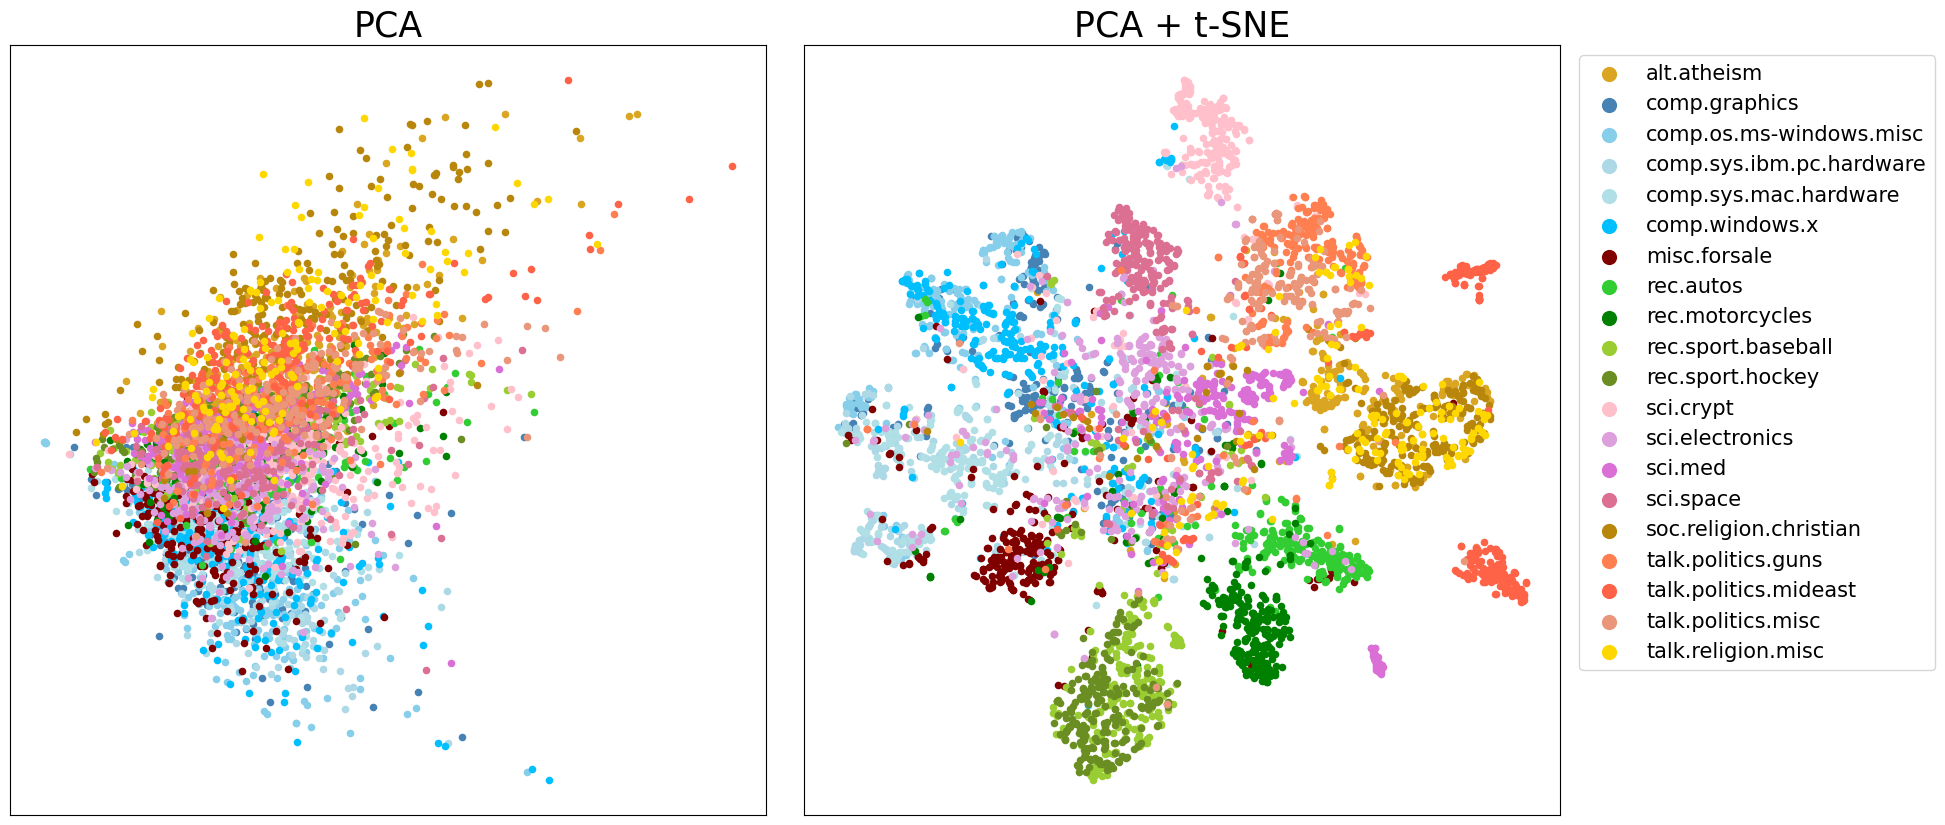

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, c=target_colour[t])
ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, alpha=1, c=target_colour[t])
ax[1].set_title(f'PCA + t-SNE', fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(
    1.51, 1), prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig(f"newsgroup.pdf", bbox_inches='tight')

## Hierarchical clustering

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

def ip_metric(X, Y):
    return np.sum(X * Y)


def ip_affinity(X):
    ips = pairwise_distances(X, metric=ip_metric)
    return np.max(ips) - ips

Find the centroids

In [ ]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx, :],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

Perform hierarchical clustering with dot products from: https://arxiv.org/abs/2305.15022

In [ ]:
ip_t_clust = AgglomerativeClustering(
    metric=ip_affinity, linkage='average', distance_threshold=0, compute_distances=True,n_clusters=None)
ip_t_clust = ip_t_clust.fit(t_zeta)

Plot dendrogram

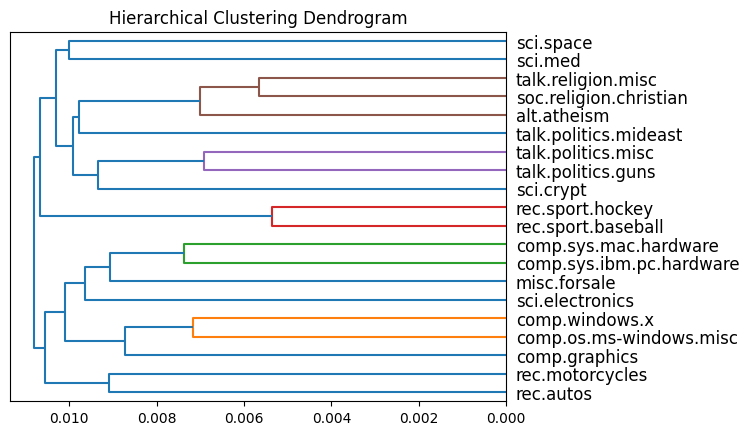

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
rs.plot_dendrogram(ip_t_clust, orientation = 'left', labels=sorted(df['target_names'].unique()))
plt.show()

In [ ]:
t_true_ranking = np.array([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1],
                           [2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [3, 2, 2, 0, 1, 2, 3, 3, 3, 3, 3,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 2, 2, 1, 0, 2, 3, 3, 3, 3, 3,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [3, 3, 3, 3, 3, 3, 3, 0, 1, 2, 2,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 1, 0, 2, 2,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 1,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 0,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               0, 1, 1, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 0, 1, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 1, 0, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 1, 1, 0, 2, 2, 2, 2, 2],
                           [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 0, 2, 2, 2, 1],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 0, 1, 1, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 1, 0, 1, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 1, 1, 0, 2],
                           [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0]])


In [ ]:
rs.kendalltau_similarity(ip_t_clust, t_true_ranking)

0.45824439241388937

## References
